In [1]:
import pandas as pd

## Reading some buckets of sales data 

In [2]:
train_data1 = pd.read_csv('../data/interim/train_2013-11_to_2014-12.csv', parse_dates=['date'])
val_data1 = pd.read_csv('../data/interim/val_2015-1.csv', parse_dates=['date'])

train_data2 = pd.read_csv('../data/interim/train_2013-1_to_2015-4.csv', parse_dates=['date'])
val_data2 = pd.read_csv('../data/interim/val_2015-5.csv', parse_dates=['date'])

train_data3 = pd.read_csv('../data/interim/train_2013-6_to_2015-6.csv', parse_dates=['date'])
val_data3 = pd.read_csv('../data/interim/val_2015-7.csv', parse_dates=['date'])

train_data4 = pd.read_csv('../data/interim/train_2013-3_to_2015-7.csv', parse_dates=['date'])
val_data4 = pd.read_csv('../data/interim/val_2015-8.csv', parse_dates=['date'])

### And additional tables

In [3]:
shops = pd.read_csv('../data/interim/shops_cities.csv')
items = pd.read_csv('../data/interim/items_etl.csv')
item_cat = pd.read_csv('../data/interim/item_categories_global.csv')

datasets = {'shops': shops, 'items': items, 'item_categories': item_cat}

## Feature extraction

I decided to define feature extraction layer as a pipeline that modifies initial data step by step. Here ate the steps:

1) getting `year` and `month` from `date`

2) grouping by month and calculating montly sales feature, our target

3) merging with `items`, `shops` and `item_categories` tables to add information (such as `city`, `item_category` and `global_category` features)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [5]:
class FeaturesFromDate(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        return X
    
class MonthlySales(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.groupby(['month','year','item_id', 'shop_id']).agg({'item_cnt_day':'sum'}).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
        return X

class MergeTables(BaseEstimator, TransformerMixin):
    def __init__(self, lookup_tables):
        self.items = lookup_tables['items']
        self.shops = lookup_tables['shops']
        self.item_cat = lookup_tables['item_categories']
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.merge(self.items, on='item_id').merge(self.shops, on='shop_id').merge(self.item_cat, on='item_category_id')
        X.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'global_cat'], axis=1, inplace=True)
        return X

feature_extraction_pipeline = Pipeline(steps = [ 
    ("date_feat", FeaturesFromDate()),
    ("montly_sales", MonthlySales()),
    ("merge", MergeTables(datasets)),
])

### Choosing best training data subset

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from datetime import datetime

In [15]:
result = []
fold = 1
models = [RandomForestRegressor(max_depth=15, n_jobs=-1),
          KNeighborsRegressor(),
          LinearRegression(),
          XGBRegressor(n_jobs=-1)]
model_type = ['RFR','KNN','LR', 'XGBR']

with tqdm(total=len(model_type) * 4) as pbar:
    for val, train in zip([val_data1, val_data2, val_data3, val_data4], [train_data1, train_data2, train_data3, train_data4]):
        
        train = feature_extraction_pipeline.fit_transform(train)
        val = feature_extraction_pipeline.transform(val)
        
        val_x = val.drop('item_cnt_month', axis=1)
        val_y = val['item_cnt_month']
        train_x = train.drop('item_cnt_month', axis=1)
        train_y = train['item_cnt_month']

        for i, model in enumerate(models):
            fit_time_start = datetime.now()
            model.fit(train_x, train_y)
            fit_time_end = datetime.now()
            y_pred = model.predict(val_x)
            pred_time_end = datetime.now()
            result.append({'type' : model_type[i],
                           'fold' : fold,
                           'data_size' : train_x.shape[0],
                           'fit_time' : (fit_time_end - fit_time_start).seconds,
                           'pred_time' : (pred_time_end - fit_time_end).seconds,
                           'mse' : mean_squared_error(val_y, y_pred),
                           'model': model})
            pbar.update(1)
        fold += 1

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
result_df = pd.DataFrame(result).drop(['model'], axis=1)
result_df

,type,fold,data_size,fit_time,mse
0,RFR,1,684007,22,91.072778
1,KNN,1,684007,2,148.770005
2,LR,1,684007,0,123.526754
3,XGBR,1,684007,9,78.418209
4,RFR,2,1414796,55,116.748093
5,KNN,2,1414796,5,118.090665
6,LR,2,1414796,0,101.527710
7,XGBR,2,1414796,22,110.672760
8,RFR,3,1184065,45,7.440141
9,KNN,3,1184065,5,17.773258


In [18]:
import seaborn as sns

<AxesSubplot:xlabel='fold', ylabel='mse'>

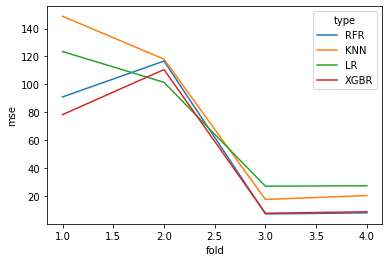

In [19]:
sns.lineplot(data=result_df, x='fold', y='mse', hue='type');

All models performed significantly better on fold 3 and 4, with *RandomForestRegressor* and *XGBRegressor* performing best on all folds (XGBR slightly better).

For now we will choose fold 3 for further experiments, since it's smaller.

## Some feature engineering and outlier handling

In [ ]:
train_x, train_y, val_x, val_y = x_y_split(train_data3, val_data3)

In [ ]:
train_trimmed_idx = (train_y > train_y.quantile(1-.99999)) & (train_y < train_y.quantile(.99999))
val_trimmed_idx = (val_y > train_y.quantile(1-.99999)) & (val_y < train_y.quantile(.99999))

In [ ]:
train_x_trimmed = train_x[train_trimmed_idx]
train_y_trimmed = train_y[train_trimmed_idx]
val_x_trimmed = val_x[val_trimmed_idx]
val_y_trimmed = val_y[val_trimmed_idx]

In [ ]:
def build_features(df, lookup_tables, history_start):
    data = df.copy()
    data['year'] = df['date'].dt.year
    data['month'] = df['date'].dt.month
    shop_appearence = train_data3.groupby('shop_id', as_index=False).agg({'date' : 'min'})
    shop_appearence['shop_first_appeared_days'] = (shop_appearence['date'] - history_start).dt.days
    shop_appearence.drop(['date'],axis=1, inplace=True)
    data = data.groupby(['month','year','item_id', 'shop_id']).agg({'item_cnt_day':'sum'}).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
    data = data.merge(lookup_tables['items'], on='item_id').merge(lookup_tables['shops'], on='shop_id').merge(lookup_tables['item_categories'], on='item_category_id')
    data['global_cat'] = data['item_category_name'].apply(lambda s: re.split(' (-|\()', s)[0])
    data.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'global_cat'], axis=1, inplace=True)
    data = data.merge(shop_appearence, on='shop_id')
    return data

def x_y_split(train_data, val_data):
    val_data['date'] = pd.to_datetime(val_data['date'], format="%Y-%m-%d")
    train_data['date'] = pd.to_datetime(train_data['date'], format="%Y-%m-%d")

    val = build_features(val_data, datasets, train_data['date'].min())
    train = build_features(train_data, datasets, train_data['date'].min())

    val_x = val.drop('item_cnt_month', axis=1)
    val_y = val['item_cnt_month']
    train_x = train.drop('item_cnt_month', axis=1)
    train_y = train['item_cnt_month']
    return train_x, train_y, val_x, val_y

In [ ]:
train_x, train_y, val_x, val_y = x_y_split(train_data3, val_data3)

In [ ]:
sales = pd.read_csv('../data/interim/sales_train_etl.csv')
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")

In [ ]:
shop_appearence = sales.groupby('shop_id').agg({'date':['min', 'max']}).reset_index()

In [ ]:
shops['first_appearence'] = shop_appearence[('date', 'min')]
shops['last_appearence'] = shop_appearence[('date', 'max')]

In [ ]:
def clip_to_timeframe(df, start_date, end_date):
    data = df.copy()
    data.loc[data['first_appearence'] < start_date, 'first_appearence'] = start_date
    data.loc[data['last_appearence'] > end_date, 'last_appearence'] = end_date
    return data

In [ ]:
shops.head(10)

In [ ]:
shops1 = clip_to_timeframe(shops, train_data3['date'].min(), val_data3['date'].max())
shops1 